In [1]:
import torch
import torch.nn as nn
import os
import numpy as np 

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Sequential(  
                        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(16),
                    )
        self.conv2 = nn.Sequential(  
                        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(32),
                    )
        self.conv3 = nn.Sequential(  
                        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                    )
        self.conv4 = nn.Sequential(  
                        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                    )
        
        
        # 定义全连接层
        self.fc1 = nn.Linear(1024//8*64, sample_num)
        
    def forward(self, x):
        # 将输入的一维向量转化为三维张量，第一维是batch size，第二维是通道数，第三维是向量长度
        x = x.unsqueeze(1)
        x = x.to(torch.float32)
        # 第一个卷积层
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # 展开张量，用于全连接层输入
        x = torch.flatten(x, start_dim=1)
        
        # 全连接层
        x = self.fc1(x)
        
        return x

/home/visitor/anaconda3/envs/1DCNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import torch.nn.functional as F

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [3]:
device = torch.device("cuda")
sample_num = 15
models = OneDCNN()
models.load_state_dict(torch.load("save/model_1DCNN_clean.pth"))
cnn = models.to(device).eval()

content_layers_default = ['conv_3']
style_layers_default = ['conv_1']

In [4]:
def get_style_model_and_losses(cnn, style_imgs, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    # normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential()

    i = 0  # increment every time we see a conv
    for layer0 in cnn.children():
        if isinstance(layer0, nn.Sequential):
            for layer in layer0.children():
                if isinstance(layer, nn.Conv1d):
                    i += 1
                    name = 'conv_{}'.format(i)
                elif isinstance(layer, nn.ReLU):
                    name = 'relu_{}'.format(i)
                    # The in-place version doesn't play very nicely with the ContentLoss
                    # and StyleLoss we insert below. So we replace with out-of-place
                    # ones here.
                    layer = nn.ReLU(inplace=False)
                elif isinstance(layer, nn.MaxPool1d):
                    name = 'pool_{}'.format(i)
                elif isinstance(layer, nn.BatchNorm1d):
                    name = 'bn_{}'.format(i)
                elif isinstance(layer, nn.Linear):
                    name = 'ln_{}'.format(i)
                else:
                    raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                    
                model.add_module(name, layer)
        
                # print(model)
                # print(style_img.shape)
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).detach()
                    content_loss = ContentLoss(target)
                    model.add_module("content_loss_{}".format(i), content_loss)
                    content_losses.append(content_loss)

                for k in range(len(style_imgs)):
                    if name in content_layers:
                        # add content loss:
                        target = model(style_imgs[i]).detach()
                        content_loss = ContentLoss(target)
                        model.add_module("content_loss_{}_{}".format(k, i), content_loss)
                        content_losses.append(content_loss)
                    if name in style_layers:
                        # add style loss:
                        target_feature = model(style_imgs[i]).detach()
                        style_loss = StyleLoss(target_feature)
                        model.add_module("style_loss_{}_{}".format(k, i), style_loss)
                        style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [5]:

import torch.optim as optim
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [6]:

def run_style_transfer(cnn, content_img, style_imgs, input_img, num_steps=20,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
#     print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_imgs, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)

    old_loss = [-1] 
    new_loss = [0]
#     print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            power = 1
            
            for sl in style_losses:
                style_score += sl.loss * power
                if power == 1:
                    power = 0.3
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))   
                new_loss[0] = style_score.item() + content_score.item()

            return style_score + content_score

        optimizer.step(closure)

        old_loss[0] = new_loss[0]
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [7]:

from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, dirs):
        self.x = None
        self.y = None
        for data_dir in dirs:
            f_list = os.listdir(data_dir)
            for idx in range(min(sample_num, len(f_list))):
                if self.x is None:
                    self.x = np.load(data_dir + str(idx+1) + '.npy')[:, :]
                else:
                    self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[:, :]))
                tempy = np.zeros((200, sample_num))
                tempy[:, idx] = 1
                if self.y is None:
                    self.y = tempy
                else:
                    self.y = np.concatenate((self.y, tempy))

        # print(self.y.shape)
        # print(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


In [8]:
def tensor2np(image):
    image = image.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0).squeeze(0)      # remove the fake batch dimension
    return image.detach().numpy().astype(np.float64)

import random
from PIL import Image
import time
import matplotlib.pyplot as plt

def do_style_transfer(from_dataset, to_dataset, weight_style, steps, seed = 0):
    
    
    weight_style = float(weight_style)
    output_list = []
    for idx_sample in range(0, 15):
        # 修正
        # temp = np.load('data/CNT_noisy_final/{}.npy'.format(idx_sample+1))
        for idx in range(0, 200):
            # 修正
            if True:
            # if idx ==120:
            # if idx in (20,25,37,48,49,57,58,80,92,103,106,113,120,137,138,141,145,186,199):
                content_img = torch.from_numpy(from_dataset[idx_sample * 200 + idx][0]).unsqueeze(0).unsqueeze(0).to(device, torch.float)
                # print(content_img.shape)
                # 使用多个style image
                style_images = []

                random.seed(time.time())

                for i in range(10):
                    idx = random.randint(0,199)
                    style_images.append(torch.from_numpy(to_dataset[idx_sample * 200 + idx][0]).unsqueeze(0).unsqueeze(0).to(device, torch.float))

                input_img = content_img.clone()
                # input_img = torch.from_numpy(np.random.rand(1, 1024)).unsqueeze(0).to(device, torch.float)

                inputs = tensor2np(content_img)

                output = run_style_transfer(cnn, content_img, style_images, input_img, style_weight=weight_style, num_steps=steps)

                output_list.append(tensor2np(output))
            else:
                output_list.append(temp[idx])
            # print(output_list[0].shape)
        
        np.save('data/CNT_clean_final/{}'.format(idx_sample+1), np.asarray(output_list))
        
        output_list = []
            
    f, axarr = plt.subplots(1, 4, figsize = (25,5))
    [axi.set_axis_off() for axi in axarr.ravel()]
    plt.subplots_adjust(wspace =0.1, hspace =0.12)
    plt.rcParams.update({'font.size': 16})

    axarr[0].set_title('Content patch')
    axarr[0].plot(inputs)
    axarr[1].set_title('Style reference')
    axarr[1].plot(tensor2np(style_images[0]))
    # print(tensor2np(style_imgs))
    axarr[2].set_title('Generated patch')
    axarr[2].plot(tensor2np(output))
    # print(tensor2np(output))
    axarr[3].set_title('Style difference')
    axarr[3].plot(tensor2np(output) - inputs)
    
    return inputs, tensor2np(style_images[0]), tensor2np(output)

run [50]:
Style Loss : 0.000002 Content Loss: 0.188299
run [50]:
Style Loss : 0.000002 Content Loss: 0.101937
run [50]:
Style Loss : 0.000027 Content Loss: 0.145465
run [50]:
Style Loss : 0.000036 Content Loss: 0.093207
run [50]:
Style Loss : 0.000026 Content Loss: 0.098927
run [50]:
Style Loss : 0.001387 Content Loss: 4.314663
run [50]:
Style Loss : 0.000002 Content Loss: 0.127796
run [50]:
Style Loss : 0.000024 Content Loss: 0.278450
run [50]:
Style Loss : 0.000086 Content Loss: 0.407419
run [50]:
Style Loss : 0.000091 Content Loss: 0.962816
run [50]:
Style Loss : 0.001383 Content Loss: 3.770525
run [50]:
Style Loss : 0.000005 Content Loss: 0.055580
run [50]:
Style Loss : 0.000021 Content Loss: 0.070869
run [50]:
Style Loss : 0.000012 Content Loss: 0.183637
run [50]:
Style Loss : 0.000005 Content Loss: 0.076406
run [50]:
Style Loss : 0.000005 Content Loss: 0.256710
run [50]:
Style Loss : 0.000056 Content Loss: 0.073675
run [50]:
Style Loss : 0.000010 Content Loss: 0.104487
run [50]:


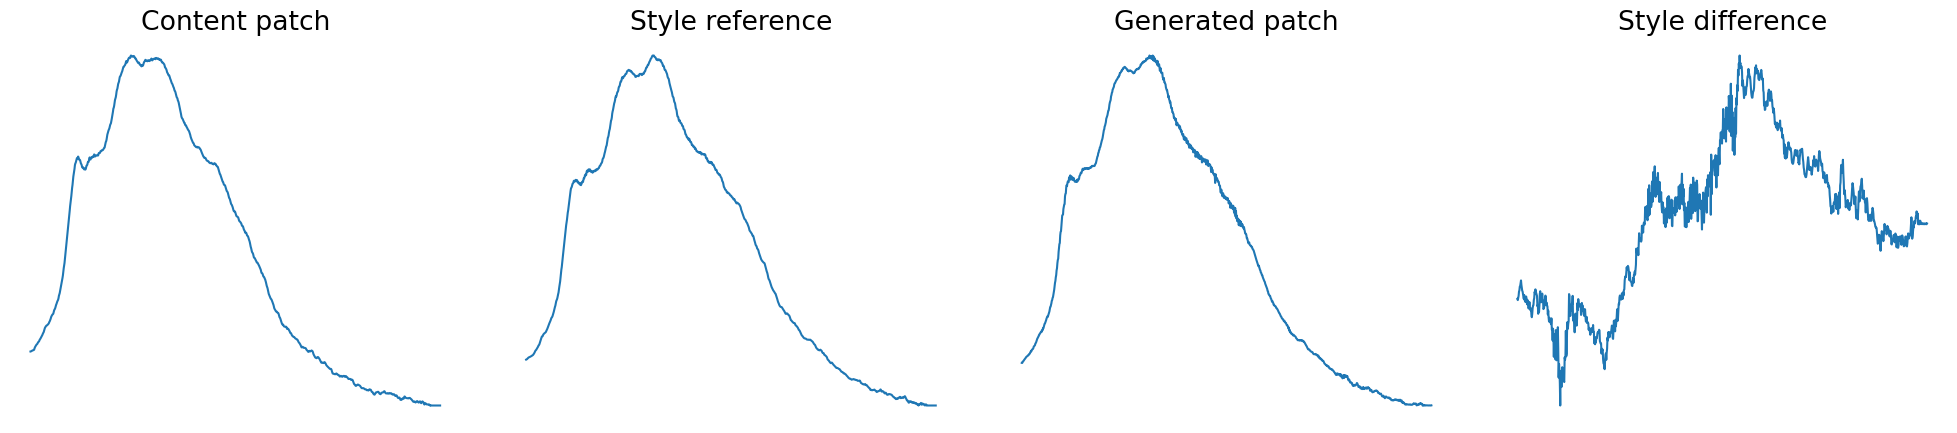

In [9]:
# to_dataset = MyDataset(['data/noisy_npy/'])
# from_dataset = MyDataset(['data/clean_npy/'])
from_dataset = MyDataset(['data/noisy_npy/'])
to_dataset = MyDataset(['data/clean_npy/'])
content_gaussian, style_gaussian, output_gaussian = do_style_transfer(from_dataset, to_dataset, '100', 60)